In [288]:
import numpy as np
import cv2 as cv
import os
from skimage import data, io, filters, measure, feature, exposure

In [289]:
def markCnt(cnt):
    M = cv.moments(cnt)
    if M['m00']>0 :
        cx = int(M['m10']/M['m00'])
        cy = int(M['m01']/M['m00'])
        cv.putText(img_c, str(i), (cx-10, cy+6), cv.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)
        return [cx,cy]
    else:
        return [0,0]
    
def isEllipse(cnt, area):
    if(len(cnt)<=5):
        return False
    else:
        ellipse = cv.fitEllipse(cnt)
        #draw ellipse
        (x, y), (MA, ma), angle = cv.fitEllipse(cnt)
        A = np.pi * MA * ma/4
        if area < 5:
            return False
        if A/area<1.2:
            return True
        else:
            return False
        
def solidityHull(cnt, area):
    hull = cv.convexHull(cnt)
    hull_area = cv.contourArea(hull)
    solidityHull = float(area)/hull_area
    
    #rysowanie
    if solidityHull>0.8:
        print(f'solidityHull:{solidityHull}')
    return solidityCircleHull
        
    
def solidityCircle(cnt, area,sc):
    (x,y),radius = cv.minEnclosingCircle(cnt)
    center = (int(x),int(y))
    solidityCircle = float(area)/(max(radius**2,0.000001) * np.pi)
    
    #rysowanie
    #if solidityCircle>sc:
        #cv.circle(img,center,int(radius),(0,255,0),2)
#       print(f'solidityCircle:{solidityCircle}')
    return solidityCircle
    
def isCircle(cnt):
    perimeter = cv.arcLength(cnt,True)
    epsilon = 0.02*perimeter
    approx = cv.approxPolyDP(cnt,epsilon,True)
    if len(approx)>5:
        #cv.drawContours(img, contours, i, (0,255,0), 3)
#         print(f'approx:{len(approx)}', end="; ")
#         print(f'isCircle', end="; ")
        return True
    else:
        return False
def dist(x1,y1,x2,y2):
    return np.sqrt((x1-x2)**2 + (y1-y2)**2)

def groupWalls(angles, latitude):
    angles = sorted(angles)
    first = angles[0]
    tmp = []
    for angle in angles:
        if angle - first > latitude:
            yield tmp
            tmp = []
        tmp.append(angle)
        first = angle
    yield tmp
    
def groupWallsByAngleDistance(circles, latitudeAngle, latitudeDistance):
    res = []
    
    circles = sorted(circles,key = lambda circle: circle.a)
    while len(circles)>0:
        cands = []
        
        first = circles[0]
        for circle in circles:
            if circle.a - first.a < latitudeAngle:
                cands.append(circle)
                first = circle
        first = cands[0]
        minD = calcMinDist(cands)
        wall = []
        for circle in cands:
            if dist(first.x, first.y, circle.x, circle.y) < minD*latitudeDistance:
                wall.append(circle)
        wallOnlyCnt = []
        for circle in wall:
            wallOnlyCnt.append(circle.i)
            index = None
            for z,c2 in enumerate(circles):
                if c2.i == circle.i:
                    index = z
            circles.pop(index)
        res.append(wallOnlyCnt)
    return res

class Circle:
    def __init__(self,i,x,y,a):
        self.i = i
        self.x = x
        self.y = y
        self.thisDistances = {}
        self.Arr =[]
        self.a = a

In [290]:
def calcDistances(circles):
    for c1 in circles:
        tmp = {}
        for c2 in circles:
            if c1.i != c2.i:
                tmp[c2.i] = dist(c1.x,c1.y,c2.x,c2.y)
        c1.Arr = sorted(tmp.items(), key =
             lambda kv:(kv[1], kv[0]))
        c1.thisDistances = tmp
def calcMinDist(circles):
    distArr = []
    for c in circles:
        for k,v in c.thisDistances.items():
            distArr.append([c.i, k, v])
    distArr = sorted(distArr, key = lambda t:t[2])
#     print(f'min :{distArr[0][0]}, {distArr[0][1]}')
    minDist = distArr[0][2]
    return minDist
def clearDir(folder):
    for filename in os.listdir(folder):
        file_path = os.path.join(folder, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)
        except Exception as e:
            print('Failed to delete %s. Reason: %s' % (file_path, e))
def addHoop(c,wall, contours):
    bgr=[0,0,0]
    bgr[(c-1)%3] = 255
    cv.putText(img_c, str(len(wall)), (10, c*25), cv.FONT_HERSHEY_SIMPLEX, 0.7, tuple(bgr), 2)
    newCounters = []
    for cnt in wall:
        newCounters.extend(contours[cnt])
    rect = cv.minAreaRect(np.array(newCounters))
    box = cv.boxPoints(rect)
    box = np.int0(box)
    cv.drawContours(img_c,[box],0,tuple(bgr),1)


In [291]:
    
    
walls_by_angle = [] #liczba oczek na ścianach
latitude = 180*0.05 #tolerancja
latitudeDistance = 5 #tolerancja odleglosc oczek na jednej scianie przemnozona razy minimalna odleglosc
aproxCircle = 0.9 #czy jest okragiem dla funkcji solidityCircle
sets = ['set/0','set/1', 'set/2', 'set/3'] #foldery z obrazami

for index,setDir in enumerate(sets):
    clearDir('result/' + str(index))
    for fileName in os.listdir(setDir):
        
        #wczytanie, przygotowanie obrazu, kontury
        print(fileName,'----------------')
        f = os.path.join(setDir, fileName)
        if os.path.isfile(f) == False:
            continue
        img = cv.imread(f, cv.IMREAD_GRAYSCALE)
        img_c = cv.imread(f)
        
        
        #imgray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        imgray = cv.GaussianBlur(img, (15,15), 2)



        p_l, p_r = np.percentile(imgray, (0, 60))#(0,2)
        imexp = exposure.rescale_intensity(imgray, in_range=(p_l, p_r))

        imscaled = cv.inRange(imexp, 90, 255)

        ret, thresh = cv.threshold(imscaled, 127, 255, cv.THRESH_BINARY+cv.THRESH_OTSU)

        contours, hierarchy = cv.findContours(thresh, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
        angles = []
        circles = []
        #cv.imwrite('thresh.png', thresh)
        for i, cnt in enumerate(contours):
            if i==0:
                continue          
            #[cx, cy] = markCnt(cnt)# centroid
            area = cv.contourArea(cnt)# powierzchnia
            #cv.drawContours(img, contours, i, (0,255,0), 3)


            #szukanie oczka ilorazie jego powierzchbni i powierzchni elipsy
            if isEllipse(cnt, area):
                #cv.ellipse(img,cv.fitEllipse(cnt),(0,255,255),2)
                ellipse = cv.fitEllipse(cnt)
                angle = ellipse[2]
                angles.append(angle)
    #             print('isEllipse--', end="; ")
    #             print(i, angle, ' ')
                if area > 40:
                    [cx, cy] = markCnt(cnt)
                    

            #solidity Hull 
            if solidityCircle(cnt, area, aproxCircle)>aproxCircle:
                angle = -1
                angles[-1] = -1

            #szukanie oczka po liczbie wierzcohlkow
            if isCircle(cnt) and isEllipse(cnt, area):
                c = Circle(i, cx, cy, angle)
                circles.append(c)
    #         print('')

        
        
        
        ## PO WYSZUKIWANIU OCZEK
        if len(circles)<2:
            print('liczba oczek:',len(circles))
            res = os.path.join('result/' + str(index), fileName)
            addHoop(1,[c.i for c in circles],contours)
            cv.imwrite(res, img_c)
            continue
        calcDistances(circles)

        print('Group by angle')
        tmp = list(groupWalls(angles, latitude))
        print(tmp)
        c = 1
        for g in tmp:
            print('liczba oczek na scianie', c, ': ', len(g))
            c += 1

        print('Group by angle and distance')
        tmp = list(groupWallsByAngleDistance(list(circles), latitude, latitudeDistance))

        c = 1
        for wall in tmp:
            print('liczba oczek na scianie', c, ': ', len(wall), ', kontury:',wall)
            if len(tmp)<=3:
                addHoop(c,wall, contours)
            c += 1
            
        #zapis obrazu
        print('')
        
        res = os.path.join('result/' + str(index), fileName)
        
        cv.imwrite(res, img_c)

print('koniec') 
# liczba oczek na scianie 1 :  17 ::: [37, 46, 41, 39, 42, 55, 33, 35, 44, 28, 16, 14, 10, 5, 1, 9, 3]
# liczba oczek na scianie 2 :  3 ::: [40, 25, 20]
# liczba oczek na scianie 3 :  12 ::: [30, 34, 24, 31, 27, 26, 22, 52, 47, 56, 54, 51]
# liczba oczek na scianie 4 :  3 ::: [53, 18, 23]
# liczba oczek na scianie 5 :  9 ::: [4, 48, 8, 2, 57, 38, 12, 23, 23]
#

1 (1).jpg ----------------
set/0\1 (1).jpg
set/0\1 (1).jpg
Group by angle
[[-1, -1]]
liczba oczek na scianie 1 :  2
Group by angle and distance
liczba oczek na scianie 1 :  2 , kontury: [1, 2]

1 (2).jpg ----------------
set/0\1 (2).jpg
set/0\1 (2).jpg
set/0\1 (2).jpg
Group by angle
[[-1, -1, -1]]
liczba oczek na scianie 1 :  3
Group by angle and distance
liczba oczek na scianie 1 :  3 , kontury: [1, 2, 3]

1 (3).jpg ----------------
set/0\1 (3).jpg
set/0\1 (3).jpg
set/0\1 (3).jpg
set/0\1 (3).jpg
set/0\1 (3).jpg
Group by angle
[[-1, -1, -1, -1, -1]]
liczba oczek na scianie 1 :  5
Group by angle and distance
liczba oczek na scianie 1 :  5 , kontury: [1, 2, 3, 4, 5]

1 (4).jpg ----------------
set/0\1 (4).jpg
set/0\1 (4).jpg
set/0\1 (4).jpg
set/0\1 (4).jpg
Group by angle
[[-1, -1, -1, -1]]
liczba oczek na scianie 1 :  4
Group by angle and distance
liczba oczek na scianie 1 :  4 , kontury: [1, 2, 3, 4]

dice.png ----------------
set/0\dice.png
set/0\dice.png
set/0\dice.png
set/0\dice.png


set/2\1 (8).jpg
set/2\1 (8).jpg
set/2\1 (8).jpg
set/2\1 (8).jpg
set/2\1 (8).jpg
set/2\1 (8).jpg
set/2\1 (8).jpg
set/2\1 (8).jpg
set/2\1 (8).jpg
set/2\1 (8).jpg
set/2\1 (8).jpg
Group by angle
[[41.768611907958984, 41.97038650512695, 46.95116424560547, 49.36675262451172, 49.64057159423828, 52.72216033935547], [90.69601440429688, 90.84192657470703, 91.47928619384766], [171.77182006835938, 172.53468322753906]]
liczba oczek na scianie 1 :  6
liczba oczek na scianie 2 :  3
liczba oczek na scianie 3 :  2
Group by angle and distance
liczba oczek na scianie 1 :  6 , kontury: [5, 16, 13, 11, 8, 3]
liczba oczek na scianie 2 :  3 , kontury: [18, 17, 19]
liczba oczek na scianie 3 :  2 , kontury: [7, 15]

1 (9).jpg ----------------
set/2\1 (9).jpg
set/2\1 (9).jpg
set/2\1 (9).jpg
set/2\1 (9).jpg
set/2\1 (9).jpg
set/2\1 (9).jpg
set/2\1 (9).jpg
set/2\1 (9).jpg
set/2\1 (9).jpg
set/2\1 (9).jpg
set/2\1 (9).jpg
set/2\1 (9).jpg
set/2\1 (9).jpg
set/2\1 (9).jpg
Group by angle
[[9.963950157165527, 13.160986900

set/2\dice3.png
set/2\dice3.png
set/2\dice3.png
set/2\dice3.png
set/2\dice3.png
set/2\dice3.png
set/2\dice3.png
set/2\dice3.png
set/2\dice3.png
set/2\dice3.png
set/2\dice3.png
set/2\dice3.png
set/2\dice3.png
set/2\dice3.png
set/2\dice3.png
Group by angle
[[17.40967559814453, 19.902385711669922, 21.186067581176758, 22.469327926635742, 26.160959243774414], [88.2541275024414, 89.13623809814453, 89.52064514160156, 89.80842590332031, 90.91358184814453, 91.415283203125], [153.81727600097656, 158.71469116210938, 160.03280639648438, 163.32183837890625]]
liczba oczek na scianie 1 :  5
liczba oczek na scianie 2 :  6
liczba oczek na scianie 3 :  4
Group by angle and distance
liczba oczek na scianie 1 :  5 , kontury: [9, 7, 5, 4, 1]
liczba oczek na scianie 2 :  6 , kontury: [15, 12, 11, 17, 16, 14]
liczba oczek na scianie 3 :  4 , kontury: [2, 3, 6, 8]

dice5.png ----------------
set/2\dice5.png
set/2\dice5.png
set/2\dice5.png
set/2\dice5.png
set/2\dice5.png
set/2\dice5.png
set/2\dice5.png
Group b

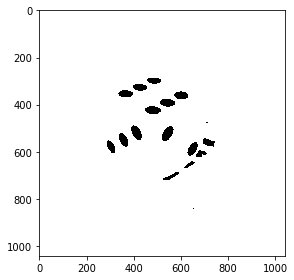

In [292]:
io.imshow(thresh)

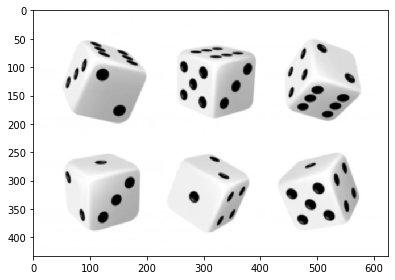

In [293]:
img2 = cv.imread('set/0/dice4.png', cv.IMREAD_GRAYSCALE)
        
#imgray = cv.cvtColor(img2, cv.COLOR_BGR2GRAY)
imgray = cv.GaussianBlur(img2, (15,15), 1)



p_l, p_r = np.percentile(imgray, (0, 60))#(0,2)
imexp = exposure.rescale_intensity(imgray, in_range=(p_l, p_r))

imscaled = cv.inRange(imexp, 90, 255)

ret, thresh = cv.threshold(imscaled, 127, 255, cv.THRESH_BINARY+cv.THRESH_OTSU)

io.imshow(imgray)
#io.imshow(thresh)

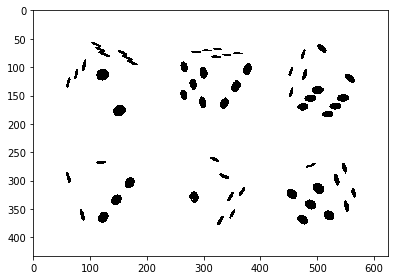

In [294]:
io.imshow(thresh)
